# AAA Northeast Customer Clustering

In [59]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [60]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [61]:
df = pd.read_csv('../data/processed_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Columns: 253 entries, Household Key to New Mover Flag
dtypes: float64(244), object(9)
memory usage: 6.8+ MB


In [62]:
df.columns[:30]

Index(['Household Key', 'Length Of Residence mean',
       'Do Not Direct Mail Solicit mean', 'Email Available mean',
       'ERS ENT Count Year 1 sum', 'ERS ENT Count Year 1 mean',
       'ERS ENT Count Year 2 sum', 'ERS ENT Count Year 2 mean',
       'ERS ENT Count Year 3 sum', 'ERS ENT Count Year 3 mean',
       'ERS Member Cost Year 1 sum', 'ERS Member Cost Year 1 mean',
       'ERS Member Cost Year 2 sum', 'ERS Member Cost Year 2 mean',
       'ERS Member Cost Year 3 sum', 'ERS Member Cost Year 3 mean',
       'Member Tenure Years mean', 'Cost 2014 sum', 'Cost 2015 sum',
       'Cost 2016 sum', 'Cost 2017 sum', 'Cost 2018 sum', 'Cost 2019 sum',
       'Total Cost sum', 'Number of Children mean', 'Income mean',
       'Credit Ranges mean', 'AssociateMember sum', 'PrimaryMember sum',
       'x0_1746.0'],
      dtype='object')

## Data Exploration
### Product Usage
Only a small portion of households using the products. The most used product has lower than 30% of the usage.<br>
Financial products under 5% won't be part of the study. They require a manual assessment, if any.

In [63]:
product_list = ['FSV CMSI Flag', 'FSV Credit Card Flag', 'FSV Deposit Program Flag', 
                'FSV Home Equity Flag', 'FSV ID Theft Flag', 'FSV Mortgage Flag',
                'INS Client Flag', 'TRV Globalware Flag', 'New Mover Flag']

In [65]:
#  Convert Y/N into 1/0, only if the OneEncoder results were not saved previously onto disk
for product in product_list:
    df[product] = np.where(df[product] == 'Y', 1, df[product])
    df[product] = np.where(df[product] == 'N', 0, df[product])

In [56]:
df_product_pct = pd.DataFrame({'Percent of Usage': df[product_list].mean()}
                             ).join(pd.DataFrame({'Count of Usage': df[product_list].sum()}))
df_product_pct.sort_values(['Percent of Usage'], ascending = False)

,Percent of Usage,Count of Usage
INS Client Flag,0.281686,989
TRV Globalware Flag,0.179151,629
FSV Credit Card Flag,0.136144,478
FSV CMSI Flag,0.082598,290
FSV ID Theft Flag,0.058103,204
New Mover Flag,0.054400,191
FSV Deposit Program Flag,0.006551,23
FSV Mortgage Flag,0.003133,11
FSV Home Equity Flag,0.000854,3


Around 45% of the households do not use any products from AAA Northeast.

In [57]:
# Logic if the encoded values remained Y/N
# df_values = df[product_list].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
# df_concat = df_values.value_counts().rename_axis('unique_values').reset_index(name='counts')
# search_val = df_concat.loc[df_concat['unique_values'] == 'NNNNNNNNN']['counts']/len(df_values)
# search_val

# Logic if the encoded values are 1/0
df_values = df[product_list].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
df_concat = df_values.value_counts().rename_axis('unique_values').reset_index(name='counts')
search_val = df_concat.loc[df_concat['unique_values'] == '000000000']['counts']/len(df_values)
search_val


0    0.452578
Name: counts, dtype: float64

## Predictive Analysis
We could use classification models to predict the probability of an household buying a product on the products with more than 1% of household usage. The models build on these products should have be better in generalization than other low-usage products.

For all products with over 5% user, apply the following process for modeling:
- Upsampling
- Create training & test set based on upsampled dataset
- Grid search using Decision Tree (Set the max of depth to 10 instead of None to avoid overfitting)
- Apply bagging with 100 estimators using decision tree and best parameters

In [24]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [25]:
%%time
product_list_to_predict = ['FSV CMSI Flag', 'FSV Credit Card Flag', 'FSV ID Theft Flag',
                           'INS Client Flag', 'TRV Globalware Flag', 'New Mover Flag']
df_prob = pd.DataFrame()
for prod in product_list:
    # Up Sampling
    # Separate majority and minority classes
    df_majority = df[df[prod]==0]
    df_minority = df[df[prod]==1]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=72) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    print('====', prod, '====')
    print(df_upsampled[prod].value_counts())
    
    # X - exclude total costs as it will be used for clustering
    cols = [x for x in df_upsampled.columns if (x not in product_list
                                               ) & (x not in ['Household Key', 'Total Cost sum'])]
    X = df_upsampled[cols]

    # y
    y = df_upsampled[prod]
        
    # Training and testing sets    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        stratify=y,
                                                        random_state=75)
    
    # Train Decision Tree
    param_grid = {'criterion': ['gini', 'entropy'],
                  'max_depth': [8, 10, 12],
                  'min_samples_split': [2, 3, 4]}
    
    gs_dt = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
    gs_dt.fit(X_train, y_train)
    print("\n== Decision Tree ==")
    print("Best Parameters:", gs_dt.best_params_)
    print("Accuracy on Training Set:", gs_dt.best_score_)

    y_pred_prob = gs_dt.predict_proba(X_test)[:,1]
    print("Accuracy on Test Set:", gs_dt.score(X_test, y_test), 
          "AUC:", roc_auc_score(y_test, y_pred_prob))
    
    y_pred_prob = gs_dt.predict_proba(df[cols])[:,1]
    print("Accuracy on Original Dataset:", gs_dt.score(df[cols], df[prod]), 
          "AUC:", roc_auc_score(df[prod], y_pred_prob))
    
    # Train Bagging 
    dt = DecisionTreeClassifier(criterion=gs_dt.best_estimator_.criterion,
                                max_depth=gs_dt.best_estimator_.max_depth,
                                min_samples_split=gs_dt.best_estimator_.min_samples_split)
    bg =  BaggingClassifier(dt, n_estimators = 100)
    bg.fit(X_train, y_train)
    print("\n== Bagging ==")
    print("Accuracy on Training Set:", bg.score(X_train, y_train))

    y_pred_prob = bg.predict_proba(X_test)[:,1]
    print("Accuracy on Test Set:", bg.score(X_test, y_test),
          "AUC:", roc_auc_score(y_test, y_pred_prob))
    
    y_pred_prob = bg.predict_proba(df[cols])[:,1]
    print("Accuracy on Original Dataset:", bg.score(df[cols], df[prod]),
          "AUC:", roc_auc_score(df[prod], y_pred_prob))
    
    y_pred = bg.predict(df[cols])
    print("Prediction Count:")
    print(pd.Series(y_pred).value_counts(), "\n")
    
    df_prob[prod] = y_pred_prob


==== FSV CMSI Flag ====
0    3221
1    3221
Name: FSV CMSI Flag, dtype: int64

== Decision Tree ==
Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 2}
Accuracy on Training Set: 1.0
Accuracy on Test Set: 1.0 AUC: 1.0
Accuracy on Original Dataset: 1.0 AUC: 1.0

== Bagging ==
Accuracy on Training Set: 1.0
Accuracy on Test Set: 1.0 AUC: 1.0
Accuracy on Original Dataset: 1.0 AUC: 1.0
Prediction Count:
0    3221
1     290
dtype: int64 

==== FSV Credit Card Flag ====
0    3033
1    3033
Name: FSV Credit Card Flag, dtype: int64

== Decision Tree ==
Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 2}
Accuracy on Training Set: 1.0
Accuracy on Test Set: 1.0 AUC: 1.0
Accuracy on Original Dataset: 1.0 AUC: 1.0

== Bagging ==
Accuracy on Training Set: 1.0
Accuracy on Test Set: 1.0 AUC: 1.0
Accuracy on Original Dataset: 1.0 AUC: 1.0
Prediction Count:
0    3033
1     478
dtype: int64 

==== FSV Deposit Program Flag ====
0    3488
1    3488
Name: F

In [26]:
df_prob.head()

,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,INS Client Flag,TRV Globalware Flag,New Mover Flag
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [27]:
df_prob.describe()

,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,INS Client Flag,TRV Globalware Flag,New Mover Flag
count,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000,3511.000000
mean,0.082598,0.136144,0.006551,0.000854,0.058103,0.003133,0.281686,0.179151,0.054400
std,0.275312,0.342990,0.080683,0.029223,0.233972,0.055894,0.449885,0.383534,0.226838
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**With high AUC on predicting all products in the original dataset, we can be confident that the probability of purchsing would be a good reference on current and potential buyers of each product.**

## Predict Cost in Next 12 Months
We can use the cost before year 2019 as year n-1, n-2, and so on to predict the cost in year 2019. Afterwards, we can use treat year 2019 as year n-1, year 2018 as year n-2, and so on to preduct the cost in year 2020. 

Based on the difinition, ERS ENT Count Year 1 and ERS Member Cost Year 1 happen in year 2019, so we can't use them to predict the cost in 2019. However, they can be used to predict the cost in 2020.

One assumption here is that the household info would remain the same in year 2020 as we don't have the projected household info of year 2020.

In [28]:
df_cost_prediction = df.drop(['Household Key', 'Total Cost sum', 
                              'ERS ENT Count Year 1 sum', 'ERS ENT Count Year 1 mean',
                              'ERS ENT Count Year 2 mean', 'ERS ENT Count Year 3 mean', 
                              'ERS Member Cost Year 1 sum', 'ERS Member Cost Year 1 mean',
                              'ERS Member Cost Year 2 mean', 'ERS Member Cost Year 3 mean'
                             ] + product_list, axis = 1)
    # Categorical variables
cat_cols = [x for x in df_cost_prediction.columns if x.startswith('x')]
for col in cat_cols:
    df_cost_prediction[col] = df_cost_prediction[col].astype('category')
df_cost_prediction = df_cost_prediction.rename(columns = 
                                               {'Cost 2018 sum': 'Cost n-1',
                                                'Cost 2017 sum': 'Cost n-2',
                                                'Cost 2016 sum': 'Cost n-3',
                                                'Cost 2015 sum': 'Cost n-4',
                                                'Cost 2014 sum': 'Cost n-5',
                                                'ERS ENT Count Year 2 sum': 'ERS ENT Count Year n-1',
                                                'ERS ENT Count Year 3 sum': 'ERS ENT Count Year n-2',
                                                'ERS Member Cost Year 2 sum': 'ERS Member Cost Year n-1',
                                                'ERS Member Cost Year 3 sum': 'ERS Member Cost Year n-2'})
df_cost_prediction.iloc[:, :25].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Length Of Residence mean         3511 non-null   float64 
 1   Do Not Direct Mail Solicit mean  3511 non-null   float64 
 2   Email Available mean             3511 non-null   float64 
 3   ERS ENT Count Year n-1           3511 non-null   float64 
 4   ERS ENT Count Year n-2           3511 non-null   float64 
 5   ERS Member Cost Year n-1         3511 non-null   float64 
 6   ERS Member Cost Year n-2         3511 non-null   float64 
 7   Member Tenure Years mean         3511 non-null   float64 
 8   Cost n-5                         3511 non-null   float64 
 9   Cost n-4                         3511 non-null   float64 
 10  Cost n-3                         3511 non-null   float64 
 11  Cost n-2                         3511 non-null   float64 
 12  Cost n

In [29]:
df_cost_prediction.head()

,Length Of Residence mean,Do Not Direct Mail Solicit mean,Email Available mean,ERS ENT Count Year n-1,ERS ENT Count Year n-2,ERS Member Cost Year n-1,ERS Member Cost Year n-2,Member Tenure Years mean,Cost n-5,Cost n-4,...,x10_N,x10_Y,x11_N,x11_Y,x12_N,x12_Y,x13_N,x13_Y,x14_N,x14_Y
0,14.000000,0.0,0.500000,1.0,4.0,58.85,347.16,32.500000,243.0,446.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,14.000000,0.0,0.750000,2.0,3.0,156.85,301.19,35.500000,0.0,58.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,15.000000,0.0,1.000000,0.0,0.0,0.00,0.00,13.000000,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,13.333333,0.0,1.000000,5.0,3.0,277.90,159.00,38.000000,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,15.000000,0.0,0.333333,0.0,0.0,0.00,0.00,27.666667,0.0,60.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


(array([2.337e+03, 2.490e+02, 5.000e+02, 6.900e+01, 4.600e+01, 1.400e+02,
        4.700e+01, 4.400e+01, 1.400e+01, 9.000e+00, 1.800e+01, 1.300e+01,
        9.000e+00, 2.000e+00, 5.000e+00, 5.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([  0.    ,  23.3668,  46.7336,  70.1004,  93.4672, 116.834 ,
        140.2008, 163.5676, 186.9344, 210.3012, 233.668 , 257.0348,
        280.4016, 303.7684, 327.1352, 350.502 , 373.8688, 397.2356,
        420.6024, 443.9692, 467.336 , 490.7028, 514.0696, 537.4364,
        560.8032, 584.17  ]),
 <BarContainer object of 25 artists>)

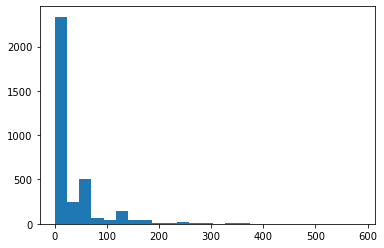

In [30]:
plt.hist(df_cost_prediction['Cost 2019 sum'], bins=25)
plt.show()

In [31]:
df_cost_prediction['Cost 2019 sum'].describe()

count    3511.000000
mean       29.002273
std        55.264674
min         0.000000
25%         0.000000
50%         0.000000
75%        58.850000
max       584.170000
Name: Cost 2019 sum, dtype: float64

In [32]:
# Percentage of households with costs greater than 0 in 2019
len(df_cost_prediction['Cost 2019 sum'
                      ][df_cost_prediction['Cost 2019 sum'
                                          ] > 0]) / len(df_cost_prediction['Cost 2019 sum'])

0.3383651381372828

**The majority of households didn't generate any costs in 2019. Therefore, the question is modified to a classification question to identify the probability of a household generating cost in 2020**

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
X = df_cost_prediction.drop(['Cost 2019 sum'], axis=1)
# y = df_cost_prediction[['Cost 2019 sum']]
y = [1 if x > 0 else 0 for x in df_cost_prediction['Cost 2019 sum']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 28)

In [35]:
%%time
param_grid = {'C': [15-6, 1e-5, 1e-4], 
              'tol': [10, 1, 0.1], 
              'max_iter': [1000, 1500]}
gs_lr = GridSearchCV(LogisticRegression(), param_grid, cv=5)
gs_lr.fit(X_train, y_train)
print("Best Parameters:", gs_lr.best_params_)
print("Accuracy on Training Set:", gs_lr.best_score_)

y_pred_prob = gs_lr.predict_proba(X_test)[:,1]
print("Accuracy on Test Set:", gs_lr.score(X_test, y_test))
print("AUC:", roc_auc_score(y_test, y_pred_prob))

y_pred_prob = gs_lr.predict_proba(X)[:,1]
print("Accuracy on Original Dataset:", bg.score(X, y),
      "AUC:", roc_auc_score(y, y_pred_prob))

Best Parameters: {'C': 9, 'max_iter': 1000, 'tol': 10}
Accuracy on Training Set: 0.7305623168247976
Accuracy on Test Set: 0.7590132827324478
AUC: 0.7649802926862099


ValueError: Number of features of the model must match the input. Model n_features is 242 and input n_features is 233.

In [36]:
y_pred = gs_lr.predict(X_test)
pd.Series(y_pred).value_counts()

0    867
1    187
dtype: int64

In [37]:
%%time
# Train Decision Tree
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 3, 5],
              'min_samples_split': [2, 3, 4]}

gs_dt = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
gs_dt.fit(X_train, y_train)
print("\n== Decision Tree ==")
print("Best Parameters:", gs_dt.best_params_)
print("Accuracy on Training Set:", gs_dt.best_score_)

y_pred_prob = gs_dt.predict_proba(X_test)[:,1]
print("Accuracy on Test Set:", gs_dt.score(X_test, y_test), 
      "AUC:", roc_auc_score(y_test, y_pred_prob))
    
y_pred_prob = gs_dt.predict_proba(X)[:,1]
print("Accuracy on Original Dataset:", gs_dt.score(X, y), 
      "AUC:", roc_auc_score(y, y_pred_prob))

# Train Bagging 
dt = DecisionTreeClassifier(criterion=gs_dt.best_estimator_.criterion,
                            max_depth=gs_dt.best_estimator_.max_depth,
                            min_samples_split=gs_dt.best_estimator_.min_samples_split)
bg =  BaggingClassifier(dt, n_estimators = 100)
bg.fit(X_train, y_train)
print("\n== Bagging ==")
print("Accuracy on Training Set:", bg.score(X_train, y_train))

y_pred_prob = bg.predict_proba(X_test)[:,1]
print("Accuracy on Test Set:", bg.score(X_test, y_test),
      "AUC:", roc_auc_score(y_test, y_pred_prob))
    
y_pred_prob = bg.predict_proba(X)[:,1]
print("Accuracy on Original Dataset:", bg.score(X, y),
      "AUC:", roc_auc_score(y, y_pred_prob))
    
y_pred = bg.predict(X)
print("Prediction Count:")
print(pd.Series(y_pred).value_counts(), "\n")


== Decision Tree ==
Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
Accuracy on Training Set: 0.7488732137830543
Accuracy on Test Set: 0.7637571157495257 AUC: 0.7615898775496469
Accuracy on Original Dataset: 0.7630304756479636 AUC: 0.7779692824354899

== Bagging ==
Accuracy on Training Set: 0.7619047619047619
Accuracy on Test Set: 0.7685009487666035 AUC: 0.7779278085551194
Accuracy on Original Dataset: 0.7638849330675022 AUC: 0.8016848786327908
Prediction Count:
0    2402
1    1109
dtype: int64 

Wall time: 4.78 s


In [38]:
df_2020_prediction = df.drop(['Household Key','Cost 2014 sum', 'Total Cost sum', 
                              'ERS ENT Count Year 3 sum', 'ERS ENT Count Year 1 mean',
                              'ERS ENT Count Year 2 mean', 'ERS ENT Count Year 3 mean', 
                              'ERS Member Cost Year 3 sum', 'ERS Member Cost Year 1 mean',
                              'ERS Member Cost Year 2 mean', 'ERS Member Cost Year 3 mean'
                             ] + product_list, axis = 1)
    # Categorical variables
cat_cols = [x for x in df_2020_prediction.columns if x.startswith('x')]
for col in cat_cols:
    df_cost_prediction[col] = df_cost_prediction[col].astype('category')
df_2020_prediction = df_2020_prediction.rename(columns=
                                               {'Cost 2019 sum': 'Cost n-1',
                                                'Cost 2018 sum': 'Cost n-2',
                                                'Cost 2017 sum': 'Cost n-3',
                                                'Cost 2016 sum': 'Cost n-4',
                                                'Cost 2015 sum': 'Cost n-5',
                                                'ERS ENT Count Year 1 sum': 'ERS ENT Count Year n-1',
                                                'ERS ENT Count Year 2 sum': 'ERS ENT Count Year n-2',
                                                'ERS Member Cost Year 1 sum': 'ERS Member Cost Year n-1',
                                                'ERS Member Cost Year 2 sum': 'ERS Member Cost Year n-2'})
df_2020_prediction.iloc[:, :25].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Length Of Residence mean         3511 non-null   float64
 1   Do Not Direct Mail Solicit mean  3511 non-null   float64
 2   Email Available mean             3511 non-null   float64
 3   ERS ENT Count Year n-1           3511 non-null   float64
 4   ERS ENT Count Year n-2           3511 non-null   float64
 5   ERS Member Cost Year n-1         3511 non-null   float64
 6   ERS Member Cost Year n-2         3511 non-null   float64
 7   Member Tenure Years mean         3511 non-null   float64
 8   Cost n-5                         3511 non-null   float64
 9   Cost n-4                         3511 non-null   float64
 10  Cost n-3                         3511 non-null   float64
 11  Cost n-2                         3511 non-null   float64
 12  Cost n-1            

In [39]:
df_prob['Cost'] = bg.predict_proba(df_2020_prediction)[:,1]
y_pred = bg.predict(df_2020_prediction)
print("Prediction Count:")
print(pd.Series(y_pred).value_counts())

Prediction Count:
0    3253
1     258
dtype: int64


In [40]:
df_prob.head()

,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,INS Client Flag,TRV Globalware Flag,New Mover Flag,Cost
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.498423
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.396900
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.132594
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.451623
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.402688


## Clustering

In [41]:
from sklearn.cluster import KMeans

d:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(


Text(0.5, 0, 'k')

Text(0, 0.5, 'Sum_of_squared_distances')

Text(0.5, 1.0, 'Elbow Method For Optimal k')

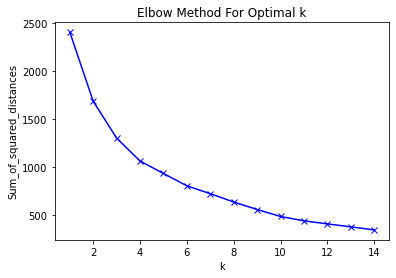

In [42]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_prob)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [43]:
df_prob = df_prob[['INS Client Flag', 'TRV Globalware Flag', 'FSV Credit Card Flag', 
                   'FSV CMSI Flag', 'FSV ID Theft Flag', 'New Mover Flag', 
                   'FSV Deposit Program Flag', 'FSV Mortgage Flag', 'FSV Home Equity Flag',
                   'Cost']]

kmeans = KMeans(n_clusters=8).fit(df_prob.iloc[:,:9])
df_prob['Cluster'] = kmeans.labels_
df_prob.head()

,INS Client Flag,TRV Globalware Flag,FSV Credit Card Flag,FSV CMSI Flag,FSV ID Theft Flag,New Mover Flag,FSV Deposit Program Flag,FSV Mortgage Flag,FSV Home Equity Flag,Cost,Cluster
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.498423,5
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.396900,0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.132594,3
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.451623,3
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.402688,7


In [44]:
import seaborn as sns

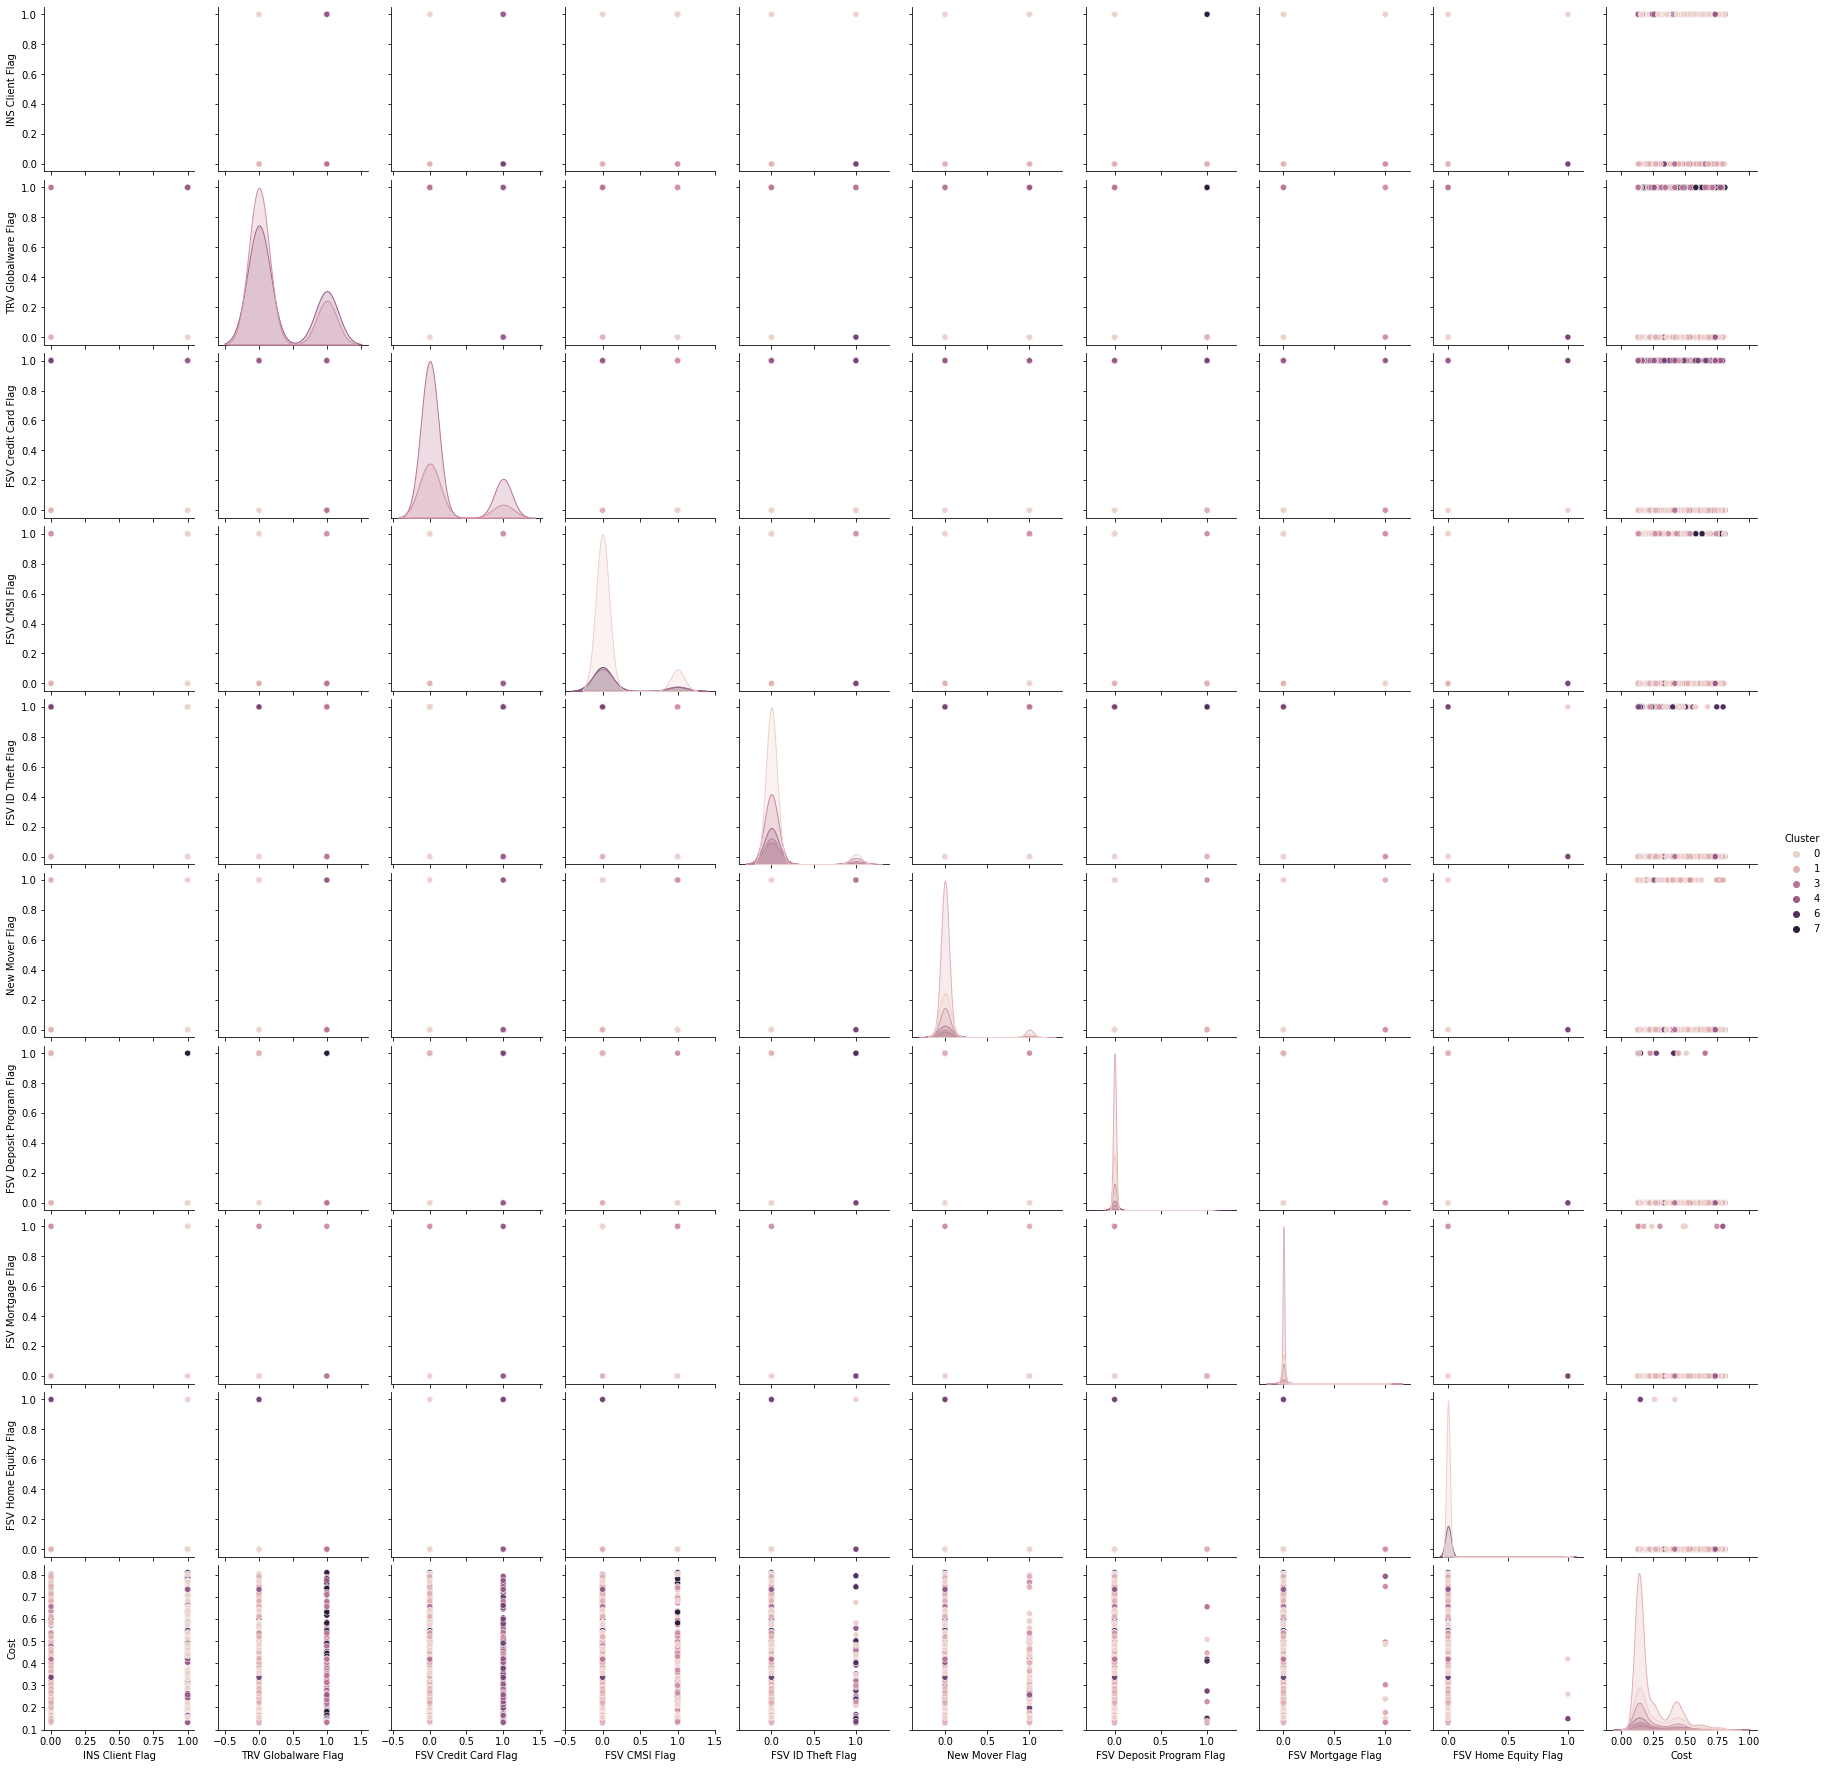

Wall time: 22.2 s


In [45]:
%%time
sns.pairplot(df_prob, hue='Cluster')
plt.show()

### Clustering Summary

#### Number of Clusters
- From the chart, it seems 3 clusters is the optimal choice, but it doesn't actually reveal any product-level insights for business action.
- When the households are clustered into **8 or 9 groups**, we can identify target audiences that shows high interest on a particular product for 7 products. 

#### Products
- The two products that do not have a particular cluster standing out are FSV Mortgage and FSV Home Equity, which also have the lowest market peneratration. For these two products, we could simply focus on individual households with high probability of purchasing instead of a particular group.

#### Cost
- In addition, predicted cost does not have any noticeable difference across clusters, partly because cost is hard to predict. The cost could possibly be generated randomly as a customer only needs it in emergency.

## Appendix
Applying other models - using 'INS Client Flag' as an example.

In [34]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

Wall time: 1min 37s


In [35]:
# Up Sampling
# Separate majority and minority classes
df_majority = df[df['INS Client Flag']==0]
df_minority = df[df['INS Client Flag']==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True, 
                                 n_samples=len(df_majority), random_state=72)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    
cols = [x for x in df_upsampled.columns if (x not in product_list
                                           ) & (x not in ['Household Key', 'Total Cost sum'])]

X = df_upsampled[cols]
# Scale 
scaler = MinMaxScaler()
scaler.fit(X)
df_scaled = scaler.transform(X)

y = df_upsampled['INS Client Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=75)

#### kNN

In [36]:
%%time
param_grid = {'n_neighbors': np.arange(8, 20)}
gs_kNN = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
gs_kNN.fit(X_train, y_train)
print("Best Number of Neighbors:", gs_kNN.best_params_)
print("Accuracy on Training Set:", gs_kNN.best_score_)

y_pred_prob = gs_kNN.predict_proba(X_test)[:,1]
print("Accuracy on Test Set:", gs_kNN.score(X_test, y_test))
print("AUC:", roc_auc_score(y_test, y_pred_prob))

Best Number of Neighbors: {'n_neighbors': 9}
Accuracy on Training Set: 0.5888475836431226
Accuracy on Test Set: 0.5966303270564915
AUC: 0.6263004871915763
Wall time: 1min 23s


#### Logistic Regression

In [37]:
%%time
param_grid = {'C': [15-6, 1e-5, 1e-4], 
              'tol': [10, 1, 0.1], 
              'max_iter': [1000, 1500]}
gs_lr = GridSearchCV(LogisticRegression(), param_grid, cv=5)
gs_lr.fit(X_train, y_train)
print("Best Parameters:", gs_lr.best_params_)
print("Accuracy on Training Set:", gs_lr.best_score_)

y_pred_prob = gs_lr.predict_proba(X_test)[:,1]
print("Accuracy on Test Set:", gs_lr.score(X_test, y_test))
print("AUC:", roc_auc_score(y_test, y_pred_prob))

Best Parameters: {'max_iter': 1000, 'C': 0.0001, 'tol': 10}
Accuracy on Training Set: 0.5563816604708798
Accuracy on Test Set: 0.5441030723488602
AUC: 0.5618890460474619
Wall time: 35.4 s


#### SVM
SVM takes too much time to train.

#### Random Forest

In [38]:
%%time
param_grid = {'n_estimators':[50, 100, 150],
              'max_depth': [3, 5], 
              'max_features': ['auto', 'sqrt']}
rf = RandomForestClassifier()
gs_rf = GridSearchCV(rf, param_grid, cv=5)
gs_rf.fit(X_train, np.ravel(y_train))
print("Best Parameters:", gs_rf.best_params_)
print("Accuracy on Training Set:", gs_rf.best_score_)

y_pred_prob = gs_rf.predict_proba(X_test)[:,1]
print("Accuracy on Test Set:", gs_rf.score(X_test, y_test))
print("AUC:", roc_auc_score(y_test, y_pred_prob))

Best Parameters: {'max_depth': 5, 'n_estimators': 100, 'max_features': 'auto'}
Accuracy on Training Set: 0.6034696406443618
Accuracy on Test Set: 0.6095143706640238
AUC: 0.6556498506993556
Wall time: 56.9 s


In [39]:
y_pred = gs_rf.predict(X_test)
pd.Series(y_pred).value_counts()

0.0    567
1.0    442
dtype: int64